In [1]:
from keras.layers               import Input, Dense, GRU, LSTM, RepeatVector
from keras.models               import Model, Sequential
from keras.layers.core          import Flatten
from keras.callbacks            import LambdaCallback
from keras.optimizers           import SGD, RMSprop, Adam
from keras.layers.wrappers      import Bidirectional as Bi
from keras.layers.wrappers      import TimeDistributed as TD
from keras.layers               import merge
from keras.applications.vgg16   import VGG16 
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization as BN
from keras.layers.noise         import GaussianNoise as GN
import numpy as np
import sys, os, io, json, re
import random
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [2]:
"""学習データの準備"""

import MeCab
import pandas as pd

# m = MeCab.Tagger('-Ochasen')
m = MeCab.Tagger(' -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')
m.parse('')  #バグ回避

data = pd.read_csv('boketeScrapy/legend.csv')

In [3]:
"""
テキスト抽出

　形態素解析してリスト形式にする
"""

import mojimoji

w_ys = []
for txt in data['txt']:
    txt_list = txt.split(",")
    for txt in txt_list:
        # 形態素解析
        ys = []
        tmp_ys = []
        only_symbol = True
        node = m.parseToNode(txt)
        while node:
            # surfaceで単語、featureで解析結果が取得できる
            surface = mojimoji.han_to_zen(node.surface, digit=False)
            features = node.feature.split(",")
            # feature = [品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用形,活用型,原形,読み,発音]
            if features[0] == "BOS/EOS" and features[-3] == "*":
                node = node.next
                continue
            if features[0] == "記号":
                # 基本的に記号がキレイに処理できない様なので無視するが、形態素解析結果が全て記号だった時はそのまま使用する
                tmp_ys.append(surface)
            else:
                ys.append(surface)
                only_symbol = False
            node = node.next

        if only_symbol is True:
            tmp_ys.append("EOS")
            ys = tmp_ys
        else:
            ys.append("EOS")
        w_ys.append(ys)

# print(w_ys)

In [4]:
'''
単語のIndex作成

形態素解析した単語の一覧辞書を作る
'''

import collections

corpus = []
for word in w_ys:
    corpus.extend(word)

"""
登場回数降順のタプルにする
collections.Counter(corpus).items(): 単語がkey, 出現回数がvalueとなる辞書を作り、[(key, val), (key, val), ...]に変換
key=lambda x:x[1]: sortedでvalをソートキーに指定
reverse=True: 降順
"""
word_id = [ (k,v) for k,v in sorted(collections.Counter(corpus).items(), key=lambda x:x[1], reverse=True) if k!="EOS" ]
# {単語:（１から始まる）ID}という辞書を作成
word_id = { k:e for e, (k,v) in enumerate(word_id, start = 1)}
word_id["EOS"] = 0
# print(word_id)

In [5]:
'''
逆引き辞書作成

{ID: 単語}という辞書を作成
'''

id_word = {v:k for k,v in word_id.items()}
# print(id_word)

In [6]:
print("All words:\t\t", len(word_id))
# 平均単語数
print("Avg. boke length:\t", np.mean(np.array([len(w) for w in w_ys])))

All words:		 1386
Avg. boke length:	 11.5527777778


In [7]:
'''
単語リストのパディング

MAX_LEN = 最大単語数
（上記の平均単語数を元に決める）
''' 

MAX_LEN = 20

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

# 形態素解析した単語を全てIDに変換する
id_ys = [[word_id[w] for w in ws] for ws in w_ys]

# MAX_LENを超えた要素に対して、超過分のtruncate、不足分を"EOS"でpddingを行う処理
# 返り値は２次元numpy配列
vec_ys = pad_sequences(id_ys, maxlen=MAX_LEN, padding='post', truncating="post", value=word_id["EOS"])

print("vector shape:\t",vec_ys.shape)

vector shape:	 (360, 20)


In [8]:
'''
単語リストをone-hot(0-1)化
'''

from keras.utils import to_categorical

# print(vec_ys)
# [277 114 147   6 236 251   9  46  86  13]

# to_categorical(): クラスベクトルa（0からlen(word_id)までの整数）を categorical_crossentropyとともに用いるためのバイナリのクラス行列に変換
Y = np.array([to_categorical(a, len(word_id)) for a in vec_ys])
# print(Y)

In [9]:
"""画像読み込み"""
X = []
for image_txt in data['images']:
    image_list = image_txt.strip('[]')
    images = re.findall(r'{.+?}', image_list)
    for image in images:
        image = image.replace("'", '"')
        image = json.loads(image)
        path = 'boketeScrapy/img/' + image['path']
        img = load_img(path, target_size=(150, 150))
        x = img_to_array(img)
        X.append(x)

X = np.asarray(X)
print(X.shape)

(360, 150, 150, 3)


In [19]:
"""
モデル生成

Getting started with the Keras functional API: https://keras.io/ja/getting-started/functional-api-guide/
"""

input_tensor = Input(shape=(150, 150, 3))
vgg_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
vgg_x = vgg_model.layers[-1].output
vgg_x = Flatten()(vgg_x)
vgg_x = Dense(768)(vgg_x)

timestep = MAX_LEN
# 入力が文章ならRepeatVectorの数は単語数になるが、今回は画像なので適正値が不明
inputs = RepeatVector(MAX_LEN)(vgg_x)
encoded = LSTM(768)(inputs)
encoder = Model(input_tensor, encoded)

DIM = len(word_id)
x = RepeatVector(MAX_LEN)(encoded)
x = Bi(LSTM(768, return_sequences=True))(x)
# 入力次元は単語辞書と同じサイズになる
decoded = TD(Dense(DIM, activation='softmax'))(x)

model = Model(input_tensor, decoded)

# for i, layer in enumerate(model.layers): # default 15
#   print( i, layer )

for layer in model.layers[:18]: # 18 is max of VGG16
  layer.trainable = False

model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
#  下記も検証してみる
# optimizer=' rmsprop'
# loss=binary_crossentropy

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [ ]:
"""学習実行"""
epoch_cnt = 1000
batch_size = 32  # データ数が少ないので、kerasのdefaultをそのまま使用

path = 'model/weights.{epoch:02d}-{loss:.2f}-{acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
# history = model.fit(X, Y,  shuffle=True, batch_size=batch_size, epochs=epoch_cnt, verbose=1, validation_split=0.1, callbacks=[model_checkpoint, early_stopping] )
history = model.fit(X, Y,  shuffle=True, batch_size=batch_size, epochs=epoch_cnt, verbose=1, callbacks=[model_checkpoint, early_stopping] )

Epoch 1/1000
360/360 [==============================] - 171s 474ms/step - loss: 3.4912 - acc: 0.5142
Epoch 2/1000
360/360 [==============================] - 166s 462ms/step - loss: 3.4055 - acc: 0.5151
Epoch 3/1000
360/360 [==============================] - 159s 442ms/step - loss: 3.3364 - acc: 0.5136
Epoch 4/1000
360/360 [==============================] - 3759s 10s/step - loss: 3.2793 - acc: 0.5144
Epoch 5/1000
360/360 [==============================] - 283s 785ms/step - loss: 3.1662 - acc: 0.5164
Epoch 6/1000
360/360 [==============================] - 7430s 21s/step - loss: 3.1206 - acc: 0.5174
Epoch 7/1000
360/360 [==============================] - 270s 750ms/step - loss: 3.0806 - acc: 0.5163
Epoch 8/1000
360/360 [==============================] - 18238s 51s/step - loss: 3.0584 - acc: 0.5186
Epoch 9/1000
360/360 [==============================] - 10058s 28s/step - loss: 2.9977 - acc: 0.5183
Epoch 10/1000
360/360 [==============================] - 18216s 51s/step - loss: 2.9851 - acc

360/360 [==============================] - 161s 447ms/step - loss: 2.3170 - acc: 0.5400
Epoch 31/1000
360/360 [==============================] - 162s 449ms/step - loss: 2.3435 - acc: 0.5408
Epoch 32/1000
360/360 [==============================] - 161s 446ms/step - loss: 2.3472 - acc: 0.5374
Epoch 33/1000
360/360 [==============================] - 1498s 4s/step - loss: 2.3157 - acc: 0.5322
Epoch 34/1000
360/360 [==============================] - 159s 442ms/step - loss: 2.3907 - acc: 0.5313
Epoch 35/1000
360/360 [==============================] - 158s 440ms/step - loss: 2.3417 - acc: 0.5339
Epoch 36/1000
360/360 [==============================] - 158s 440ms/step - loss: 2.3475 - acc: 0.5344
Epoch 37/1000
360/360 [==============================] - 157s 437ms/step - loss: 2.3743 - acc: 0.5336
Epoch 38/1000
360/360 [==============================] - 158s 438ms/step - loss: 2.3336 - acc: 0.5317
Epoch 39/1000
360/360 [==============================] - 159s 441ms/step - loss: 2.2594 - acc: 0.5

360/360 [==============================] - 170s 473ms/step - loss: 1.9423 - acc: 0.5656
Epoch 65/1000
360/360 [==============================] - 168s 466ms/step - loss: 1.8842 - acc: 0.5746
Epoch 66/1000
360/360 [==============================] - 162s 450ms/step - loss: 1.8267 - acc: 0.5811
Epoch 67/1000
360/360 [==============================] - 160s 443ms/step - loss: 1.8231 - acc: 0.5813
Epoch 68/1000
360/360 [==============================] - 158s 440ms/step - loss: 1.8088 - acc: 0.5790
Epoch 69/1000
360/360 [==============================] - 159s 441ms/step - loss: 1.7358 - acc: 0.5961
Epoch 70/1000
360/360 [==============================] - 160s 444ms/step - loss: 1.6933 - acc: 0.6018
Epoch 71/1000
360/360 [==============================] - 2040s 6s/step - loss: 1.7092 - acc: 0.5947
Epoch 72/1000
360/360 [==============================] - 1729s 5s/step - loss: 1.7123 - acc: 0.6031
Epoch 73/1000
360/360 [==============================] - 3849s 11s/step - loss: 1.7453 - acc: 0.5957

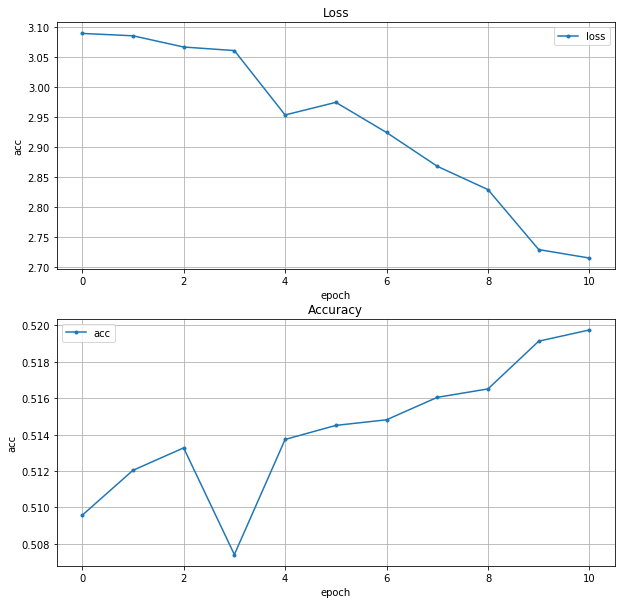

In [14]:
# 学習結果をグラフ表示

import matplotlib.pyplot as plt
# plot results
loss = history.history['loss']
# val_loss = history.history['val_loss']

acc = history.history['acc']
# val_acc = history.history['val_acc']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
# plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
# plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [ ]:
"""学習モデルをロード"""

w = ''
model.load_weights(w)

In [18]:
# ボケ実行

# 画像をnp.array()にする
f = "829a7d1d730e058be4b448d308b95fb4_600"
path_test = "img/" + f + ".jpg"
X_test = []
img_test = load_img(path_test, target_size=(150, 150))
x_test = img_to_array(img_test)
X_test.append(x_test)
X_test = np.asarray(X_test)

# 予測実行
pred = model.predict(X_test)
print(pred.shape)

# 予測結果を元にid_wordから文字列を抽出
for p in pred[0]:
    if np.argmax(p) == 0:
        break
    print(id_word[int(np.argmax(p))], end=" ")

(1, 20, 1386)
屁 が の た が 